In [117]:
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn as nn
import torch.nn.functional as F

In [118]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, counts, labels, ids, transforms = lambda x: x):
        self.imgs = imgs
        self.labels = labels
        self.counts = counts
        self.labels = labels
        self.transforms = transforms
        self.ids = ids

    def __getitem__(self, i, return_id = False):
        y = self.labels[i]
        if return_id:
            return (self.transforms(self.imgs[i].unsqueeze(0)), y, self.counts[i], self.ids[i])
        return (self.transforms(self.imgs[i].unsqueeze(0)), y, self.counts[i])

    def __len__(self):
        return len(self.imgs)

In [119]:
class SimpleVehicleNet(nn.Module):
    def __init__(self, num_bins=5, num_count_classes = 7):  # num_bins = number of vehicle count buckets
        super(SimpleVehicleNet, self).__init__()
        self.num_count_classes = num_count_classes
        # Input: [B, 1, 585, 130]
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 585, 130]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 16, 292, 65]

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, 292, 65]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 32, 146, 32]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # [B, 64, 146, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # [B, 64, 1, 1]
        )

        self.flatten = nn.Flatten()  # → [B, 64]

        # Regression head (predict scalar count)
        self.count_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_count_classes)
        )

        # Distribution head (predict vehicle count histogram)
        self.dist_head = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_bins)  # Output: raw logits → apply log_softmax
        )
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.kl = nn.KLDivLoss(reduction = "batchmean")
        self.lambda_count = 10
        self.lambda_kl = 1
        self.lambda_mse = 1
        self.freq = torch.Tensor([3.8822e-02, 5.4998e-03, 8.6703e-01, 4.8528e-03, 0.0000e+00, 0.0000e+00,
        3.2352e-04, 8.3468e-02])

    def masked_mse(self, y_pred, y_true):
        # Create a mask where target is non-zero
        mask = (y_true != 0).float()
        
        # Compute squared error only where mask == 1
        loss = (mask * (y_pred - y_true) ** 2)
        
        # Avoid division by zero: normalize by number of non-zero elements
        return loss.sum() / (mask.sum() + 1e-8)

    def weighted_mse(self, y_pred, y_true):
        weights = 1.0 / (self.freq + 1e-6)
        weights = weights / weights.sum()
        weights = weights.to(y_pred.device)
        loss = weights * (y_pred - y_true) ** 2
        return loss.mean()
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        count = self.count_head(x)                      # shape: [B, 1]
        dist_logits = self.dist_head(x)                # shape: [B, num_bins]
        dist_output = F.softmax(dist_logits, dim=1)
        return count, dist_output

    def loss(self, count_out, hist_out, count_label, hist_label):
        label = F.one_hot(count_label, num_classes = self.num_count_classes).float()
        #print(count_out.shape, label.shape)
        #print(count_out.dtype, label.dtype)
        count_loss = self.cross_entropy(count_out, label)
        row_sums = hist_label.sum(dim=1, keepdim=True)
        normalized = hist_label / row_sums
        #hist_loss = self.weighted_mse(hist_out, hist_label)
        hist_loss = self.cross_entropy(hist_out, normalized)
        return self.lambda_count * count_loss + hist_loss

In [120]:
class CountCNN(nn.Module):
    def __init__(self, classes = 7):  # num_bins = number of vehicle count buckets
        super(CountCNN, self).__init__()

        # Input: [B, 1, 585, 130]
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 585, 130]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 16, 292, 65]

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, 292, 65]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 32, 146, 32]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # [B, 64, 146, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # [B, 64, 1, 1]
        )

        self.flatten = nn.Flatten()  # → [B, 64]

        # Regression head (predict scalar count)
        self.count_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, classes)
        )
        
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.freq = torch.Tensor([3.8822e-02, 5.4998e-03, 8.6703e-01, 4.8528e-03, 0.0000e+00, 0.0000e+00,
        3.2352e-04, 8.3468e-02])
        self.classes = classes
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        count = self.count_head(x)                      # shape: [B, 1]
        return count

    def loss(self, count_out, count_label):
        label = F.one_hot(count_label, num_classes = self.classes).float()
        count_loss = self.cross_entropy(count_out, count_label)
        return count_loss

In [121]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x
        
class Resnet18(nn.Module):
    
    def __init__(self, image_channels = 1):
        
        super(Resnet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.make_layer(64, 64, stride=1)
        self.layer2 = self.make_layer(64, 128, stride=2)
        self.layer3 = self.make_layer(128, 256, stride=2)
        self.layer4 = self.make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
    def make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [122]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

def append_dropout(model, rate=0.2):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.Linear):
            new = nn.Sequential(module, nn.Dropout2d(p=rate))
            setattr(model, name, new)
            
class VehicleCounterNet(nn.Module):
    def __init__(self, num_classes=5, count_classes = 7, p = 0.3):
        super(VehicleCounterNet, self).__init__()

        # Load pretrained ResNet18 and modify
        self.backbone = Resnet18()
        num_features = 512
        # Output head 1: Regress or classify number of vehicles
        self.vehicle_count = nn.Sequential(
                                           nn.Linear(num_features, num_features//2),
                                           nn.BatchNorm1d([num_features//2]),
                                           nn.Dropout(p),
                                           nn.ReLU(),
                                           nn.Linear(num_features//2, count_classes))

        # Output head 2: Predict histogram (e.g., soft count distribution across possible values)
        self.histogram_head = nn.Sequential(nn.Linear(num_features, num_features//2),
                                           nn.BatchNorm1d([num_features//2]),
                                           nn.ReLU(),
                                           nn.Linear(num_features//2, num_classes))
        self.cross_entropy = nn.CrossEntropyLoss()
        self.freq = torch.Tensor([3.8822e-02, 5.4998e-03, 8.6703e-01, 4.8528e-03, 8.3468e-02])
        weights = 1e-12 + self.freq # [1, num_classes]
        weights = 1/weights
        self.weights = torch.clip(weights, 1, 2)
        #lambda P, Q: -torch.sum(self.freq*P*torch.log(Q + 1e-9))
        self.mse = nn.MSELoss()
        self.kl = nn.KLDivLoss(reduction = "batchmean")
        self.lambda_count = 1
        self.lambda_kl = 10
        self.lambda_mse = 1
        self.count_classes = count_classes

    def forward(self, x):
        features = self.backbone(x)
        count_output = self.vehicle_count(features)
        histogram_output = F.softmax(self.histogram_head(features), dim = 1)
        return count_output, histogram_output

    def masked_mse(self, y_pred, y_true):
        # Create a mask where target is non-zero
        mask = (y_true != 0).float()
        
        # Compute squared error only where mask == 1
        loss = (mask * (y_pred - y_true) ** 2)
        
        # Avoid division by zero: normalize by number of non-zero elements
        return loss.sum() / (mask.sum() + 1e-8)
    
    def weighted_soft_nll_loss(self, log_probs, soft_targets):
        """
        log_probs: Tensor of shape [batch_size, num_classes], output of log_softmax
        soft_targets: Tensor of shape [batch_size, num_classes], target distributions
        class_weights: Tensor of shape [num_classes], weight per class
        """
        weights = self.weights.unsqueeze(0).to(log_probs.device)  # [1, num_classes]
        
        # Apply weights to soft_targets
        weighted_targets = soft_targets * weights  # [batch_size, num_classes]
        
        # Compute element-wise product: -weighted_targets * log_probs
        loss = -torch.sum(weighted_targets * log_probs, dim=1)  # [batch_size]
        
        return loss.mean()  # or use .sum() if preferred

    def loss(self, count_out, hist_out, count_label, hist_label):
        count_label = F.one_hot(count_label, self.count_classes).float()
        count_loss = self.cross_entropy(count_out, count_label)
        target = hist_label + 1e-8
        target_probs = (target) / target.sum(dim=1, keepdim=True)
        expected_hist_loss = self.weighted_soft_nll_loss(torch.log(hist_out), target_probs)
        #mse_loss = self.mse(count_label * hist_label, torch.argmax(count_out, dim = -1).unsqueeze(-1) * hist_out)
        total_loss = (
            self.lambda_count * count_loss +
            self.lambda_kl * expected_hist_loss
         #   self.lambda_mse * mse_loss
        )
        
        return total_loss

In [123]:
import os
from datetime import datetime

class Logger:
  def __init__(self, log_dir, filename='train_log.txt'):
      os.makedirs(log_dir, exist_ok=True)
      timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
      self.log_dir = log_dir
      self.log_path = os.path.join(log_dir, f'{timestamp}_{filename}')

      with open(self.log_path, 'w') as f:
          f.write(f"Logging started: {timestamp}\n\n")

  def log(self, message):
      timestamp = datetime.now().strftime('%H:%M:%S')
      full_message = f"[{timestamp}] {message}"
      print(full_message)  # also print to stdout
      with open(self.log_path, 'a') as f:
          f.write(full_message + '\n')

  def log_metrics(self, epoch, train_loss=None, val_loss=None, **kwargs):
      msg = f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
      for k, v in kwargs.items():
          msg += f" | {k}: {v:.4f}" if isinstance(v, float) else f" | {k}: {v}"
      self.log(msg)

  def save_checkpoint(self, path, model, optimizer, epoch, best_val_loss):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_val_loss': best_val_loss
    }
    torch.save(checkpoint, os.path.join(self.log_dir, path))


In [124]:

data = torch.load("/kaggle/input/das-data-v2/data.pt")

/tmp/ipykernel_31/3359385956.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("/kaggle/input/das-data-v2/data.pt")


In [125]:
print(data)

{'imgs': tensor([[[ -77.2581,  -81.7283,  -89.9515,  ...,  -87.0181,  -79.7682,
           -89.3360],
         [ -76.6283,  -69.6069,  -85.6036,  ...,  -85.7513,  -82.9768,
           -86.4621],
         [ -79.1442,  -69.5605,  -87.3304,  ...,  -81.3000,  -84.2434,
           -94.8705],
         ...,
         [ -74.2253,  -73.9507,  -79.7667,  ...,  -85.7920,  -85.0900,
           -88.9283],
         [ -92.2295,  -83.9549,  -76.0350,  ...,  -88.2298,  -88.1630,
           -81.9623],
         [ -83.9844,  -80.3902, -100.4874,  ...,  -94.8631,  -86.7769,
           -90.7864]],

        [[ -81.1645,  -93.0901,  -69.2779,  ...,  -91.8404,  -90.7840,
           -93.5275],
         [ -85.8206,  -76.4980,  -77.8869,  ...,  -88.0272, -100.2061,
           -86.4210],
         [ -85.9559,  -79.2383,  -79.7804,  ...,  -87.2068,  -90.7048,
           -88.6315],
         ...,
         [ -85.7070,  -93.9815,  -84.2708,  ...,  -61.3353,  -63.4134,
           -69.7668],
         [ -82.8358,  -85.3931,

In [126]:
import matplotlib.pyplot as plt
counts = data["counts"]
print(torch.unique(counts, return_counts = True))

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19]), tensor([309, 111,  85,  77, 253, 122, 109,  85,  73, 100,  29,  13,  11,   3,
          8,   1,   1,   1]))


In [127]:
filtered_data = {}
filtered_data["imgs"] = []
filtered_data["counts"] = []
filtered_data["labels"] = []
filtered_data["ids"] = []
#filter out when counts <= 6
for i in range(len(counts)):
    if counts[i] <= 6:
        for k in ["imgs", "counts", "labels", "ids"]:
            filtered_data[k].append(data[k][i].tolist())

In [128]:
for k in ["imgs", "counts", "labels", "ids"]:
    filtered_data[k] = torch.tensor(filtered_data[k])
    print(filtered_data[k].shape)

torch.Size([957, 585, 153])
torch.Size([957])
torch.Size([957, 8])
torch.Size([957])


In [129]:
filtered_data["labels"] = torch.hstack((filtered_data["labels"][:, :4], filtered_data["labels"][:, 7:]))

In [130]:
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import v2
images = filtered_data["imgs"]
counts = filtered_data["counts"]
labels = filtered_data["labels"]
ids = filtered_data["ids"]
train_transform = v2.Compose([
    v2.RandomHorizontalFlip(),         # flip image horizontally
    v2.RandomVerticalFlip(),
    v2.ToTensor(),                     # convert to tensor
    v2.Normalize((0.5, ), (0.5, ))            # normalize
])
from sklearn.model_selection import train_test_split
train_imgs, test_imgs, train_counts, test_counts, train_labels, test_labels, train_ids, test_ids = train_test_split(images, counts, labels, ids, test_size = 0.1)
train_ds = Dataset(train_imgs, train_counts, train_labels, ids, transforms = train_transform)
test_ds = Dataset(test_imgs, test_counts, test_labels, ids, transforms = v2.Normalize((0.5, ), (0.5, )))

In [131]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

In [132]:
model = VehicleCounterNet(p = 0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
logger = Logger("/kaggle/working/182_proj_logs_cross_entropy/")
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(test_ds)
# Loss and optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-4)
train_losses = []
val_losses = []
# Training loop
num_epochs = 50
best_val_loss = float('inf')
best_val_acc = 0
logger.save_checkpoint("best_model.pth", model, optimizer, 0, best_val_loss)
for epoch in tqdm(range(num_epochs)):
    # --------- Train ---------
    model.train()
    train_loss = 0.0
    train_count_correct = 0
    train_label_correct = 0
    train_total = 0

    for images, labels, counts in train_loader:
        images = images.to(device).float()
        labels = labels.to(device).float()
        counts = counts.to(device).long()
        optimizer.zero_grad()
        count_output, label_output = model(images)
        loss = model.loss(count_output, label_output, counts, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(count_output, dim = -1)
        label_preds = preds.unsqueeze(-1) * label_output
        train_count_correct += (preds == counts).sum().item()
        train_label_correct += (torch.round(label_preds).flatten() == labels.flatten()).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_acc_count = train_count_correct / train_total
    train_acc_label = train_label_correct / (5*train_total)

    # --------- Validate ---------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_label_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels, counts in val_loader:
            images = images.to(device).float()
            labels = labels.to(device).float()
            counts = counts.to(device).long()#.unsqueeze(1)
            count_output, label_output = model(images)
            loss = model.loss(count_output, label_output, counts, labels)
            val_loss += loss.item()
            preds = torch.argmax(count_output, dim = -1)
            label_preds = preds.unsqueeze(-1) * label_output
            val_correct += (preds == counts.flatten()).sum().item()
            val_label_correct += (torch.round(label_output).flatten() == labels.flatten()).sum().item()
            val_total += labels.size(0)
            
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = val_correct / val_total
    val_acc_label = val_label_correct / (5*val_total)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        logger.save_checkpoint("best_model.pth", model, optimizer, epoch, best_val_acc)

    # --------- Print results ---------
    
    logger.log(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.2f} | Count Acc: {train_acc_count:.2f} | Label Acc: {train_acc_label:.2f}"
          f"|| Val Loss: {avg_val_loss:.2f} | Count Acc: {val_acc:.2f} | Label Acc: {val_acc_label:.2f}")
    '''
    logger.log(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.2f} | Count Acc: {train_acc_count:.2f}"
          f"|| Val Loss: {avg_val_loss:.2f} | Count Acc: {val_acc:.2f}")   
    '''

  2%|▏         | 1/50 [00:04<03:27,  4.23s/it]

[17:34:42] Epoch 1/50 Train Loss: 12.69 | Count Acc: 0.35 | Label Acc: 0.65|| Val Loss: 116.89 | Count Acc: 0.36 | Label Acc: 0.82


  4%|▍         | 2/50 [00:08<03:23,  4.24s/it]

[17:34:46] Epoch 2/50 Train Loss: 9.26 | Count Acc: 0.44 | Label Acc: 0.75|| Val Loss: 9.42 | Count Acc: 0.40 | Label Acc: 0.82


  6%|▌         | 3/50 [00:12<03:19,  4.24s/it]

[17:34:50] Epoch 3/50 Train Loss: 8.93 | Count Acc: 0.44 | Label Acc: 0.76|| Val Loss: 8.99 | Count Acc: 0.43 | Label Acc: 0.82


  8%|▊         | 4/50 [00:16<03:08,  4.11s/it]

[17:34:54] Epoch 4/50 Train Loss: 8.90 | Count Acc: 0.44 | Label Acc: 0.75|| Val Loss: 10.80 | Count Acc: 0.43 | Label Acc: 0.82


 10%|█         | 5/50 [00:20<03:06,  4.15s/it]

[17:34:58] Epoch 5/50 Train Loss: 8.79 | Count Acc: 0.45 | Label Acc: 0.76|| Val Loss: 8.90 | Count Acc: 0.48 | Label Acc: 0.82


 12%|█▏        | 6/50 [00:25<03:04,  4.19s/it]

[17:35:03] Epoch 6/50 Train Loss: 8.77 | Count Acc: 0.45 | Label Acc: 0.75|| Val Loss: 9.84 | Count Acc: 0.49 | Label Acc: 0.82


 14%|█▍        | 7/50 [00:29<03:00,  4.20s/it]

[17:35:07] Epoch 7/50 Train Loss: 8.75 | Count Acc: 0.46 | Label Acc: 0.75|| Val Loss: 8.18 | Count Acc: 0.55 | Label Acc: 0.82


 16%|█▌        | 8/50 [00:33<02:52,  4.12s/it]

[17:35:11] Epoch 8/50 Train Loss: 8.82 | Count Acc: 0.46 | Label Acc: 0.76|| Val Loss: 10.91 | Count Acc: 0.41 | Label Acc: 0.82


 18%|█▊        | 9/50 [00:37<02:45,  4.04s/it]

[17:35:15] Epoch 9/50 Train Loss: 8.57 | Count Acc: 0.48 | Label Acc: 0.76|| Val Loss: 10.81 | Count Acc: 0.23 | Label Acc: 0.82


 20%|██        | 10/50 [00:41<02:39,  3.99s/it]

[17:35:19] Epoch 10/50 Train Loss: 8.49 | Count Acc: 0.47 | Label Acc: 0.77|| Val Loss: 8.61 | Count Acc: 0.51 | Label Acc: 0.82


 22%|██▏       | 11/50 [00:45<02:38,  4.07s/it]

[17:35:23] Epoch 11/50 Train Loss: 8.33 | Count Acc: 0.46 | Label Acc: 0.75|| Val Loss: 8.67 | Count Acc: 0.58 | Label Acc: 0.82


 24%|██▍       | 12/50 [00:49<02:32,  4.01s/it]

[17:35:27] Epoch 12/50 Train Loss: 8.29 | Count Acc: 0.47 | Label Acc: 0.78|| Val Loss: 9.15 | Count Acc: 0.50 | Label Acc: 0.82


 26%|██▌       | 13/50 [00:53<02:26,  3.97s/it]

[17:35:31] Epoch 13/50 Train Loss: 8.42 | Count Acc: 0.47 | Label Acc: 0.76|| Val Loss: 8.29 | Count Acc: 0.56 | Label Acc: 0.82


 28%|██▊       | 14/50 [00:56<02:21,  3.94s/it]

[17:35:34] Epoch 14/50 Train Loss: 8.28 | Count Acc: 0.49 | Label Acc: 0.78|| Val Loss: 12.51 | Count Acc: 0.12 | Label Acc: 0.82


 30%|███       | 15/50 [01:00<02:17,  3.92s/it]

[17:35:38] Epoch 15/50 Train Loss: 8.65 | Count Acc: 0.47 | Label Acc: 0.77|| Val Loss: 10.54 | Count Acc: 0.39 | Label Acc: 0.82


 32%|███▏      | 16/50 [01:04<02:13,  3.91s/it]

[17:35:42] Epoch 16/50 Train Loss: 8.31 | Count Acc: 0.46 | Label Acc: 0.76|| Val Loss: 8.33 | Count Acc: 0.53 | Label Acc: 0.82


 34%|███▍      | 17/50 [01:08<02:08,  3.90s/it]

[17:35:46] Epoch 17/50 Train Loss: 8.06 | Count Acc: 0.48 | Label Acc: 0.77|| Val Loss: 18.52 | Count Acc: 0.36 | Label Acc: 0.82


 36%|███▌      | 18/50 [01:12<02:04,  3.89s/it]

[17:35:50] Epoch 18/50 Train Loss: 8.00 | Count Acc: 0.48 | Label Acc: 0.77|| Val Loss: 14.32 | Count Acc: 0.15 | Label Acc: 0.72


 38%|███▊      | 19/50 [01:16<02:00,  3.89s/it]

[17:35:54] Epoch 19/50 Train Loss: 8.04 | Count Acc: 0.48 | Label Acc: 0.78|| Val Loss: 13.71 | Count Acc: 0.36 | Label Acc: 0.82


 40%|████      | 20/50 [01:20<01:56,  3.88s/it]

[17:35:58] Epoch 20/50 Train Loss: 8.02 | Count Acc: 0.47 | Label Acc: 0.78|| Val Loss: 10.11 | Count Acc: 0.34 | Label Acc: 0.82


 42%|████▏     | 21/50 [01:24<01:52,  3.89s/it]

[17:36:02] Epoch 21/50 Train Loss: 7.87 | Count Acc: 0.48 | Label Acc: 0.78|| Val Loss: 12.58 | Count Acc: 0.12 | Label Acc: 0.82


 44%|████▍     | 22/50 [01:27<01:48,  3.89s/it]

[17:36:05] Epoch 22/50 Train Loss: 7.92 | Count Acc: 0.49 | Label Acc: 0.79|| Val Loss: 9.18 | Count Acc: 0.40 | Label Acc: 0.82


 46%|████▌     | 23/50 [01:31<01:45,  3.89s/it]

[17:36:09] Epoch 23/50 Train Loss: 7.95 | Count Acc: 0.48 | Label Acc: 0.78|| Val Loss: 7.85 | Count Acc: 0.52 | Label Acc: 0.82


 48%|████▊     | 24/50 [01:35<01:41,  3.89s/it]

[17:36:13] Epoch 24/50 Train Loss: 7.95 | Count Acc: 0.48 | Label Acc: 0.78|| Val Loss: 13.49 | Count Acc: 0.41 | Label Acc: 0.82


 50%|█████     | 25/50 [01:39<01:37,  3.89s/it]

[17:36:17] Epoch 25/50 Train Loss: 7.81 | Count Acc: 0.48 | Label Acc: 0.79|| Val Loss: 10.90 | Count Acc: 0.35 | Label Acc: 0.80


 52%|█████▏    | 26/50 [01:43<01:33,  3.89s/it]

[17:36:21] Epoch 26/50 Train Loss: 7.59 | Count Acc: 0.50 | Label Acc: 0.80|| Val Loss: 12.32 | Count Acc: 0.23 | Label Acc: 0.77


 54%|█████▍    | 27/50 [01:47<01:29,  3.88s/it]

[17:36:25] Epoch 27/50 Train Loss: 7.53 | Count Acc: 0.50 | Label Acc: 0.80|| Val Loss: 13.63 | Count Acc: 0.06 | Label Acc: 0.72


 56%|█████▌    | 28/50 [01:51<01:25,  3.88s/it]

[17:36:29] Epoch 28/50 Train Loss: 7.58 | Count Acc: 0.49 | Label Acc: 0.79|| Val Loss: 10.64 | Count Acc: 0.28 | Label Acc: 0.82


 58%|█████▊    | 29/50 [01:55<01:21,  3.89s/it]

[17:36:33] Epoch 29/50 Train Loss: 7.75 | Count Acc: 0.48 | Label Acc: 0.79|| Val Loss: 16.51 | Count Acc: 0.09 | Label Acc: 0.61


 60%|██████    | 30/50 [01:59<01:17,  3.89s/it]

[17:36:37] Epoch 30/50 Train Loss: 7.93 | Count Acc: 0.50 | Label Acc: 0.79|| Val Loss: 12.65 | Count Acc: 0.47 | Label Acc: 0.82


 62%|██████▏   | 31/50 [02:02<01:13,  3.89s/it]

[17:36:40] Epoch 31/50 Train Loss: 7.37 | Count Acc: 0.48 | Label Acc: 0.79|| Val Loss: 10.12 | Count Acc: 0.32 | Label Acc: 0.82


 64%|██████▍   | 32/50 [02:06<01:10,  3.89s/it]

[17:36:44] Epoch 32/50 Train Loss: 7.41 | Count Acc: 0.49 | Label Acc: 0.80|| Val Loss: 11.50 | Count Acc: 0.34 | Label Acc: 0.82


 66%|██████▌   | 33/50 [02:10<01:06,  3.89s/it]

[17:36:48] Epoch 33/50 Train Loss: 7.40 | Count Acc: 0.50 | Label Acc: 0.80|| Val Loss: 10.54 | Count Acc: 0.46 | Label Acc: 0.82


 68%|██████▊   | 34/50 [02:14<01:02,  3.89s/it]

[17:36:52] Epoch 34/50 Train Loss: 7.51 | Count Acc: 0.48 | Label Acc: 0.80|| Val Loss: 8.19 | Count Acc: 0.50 | Label Acc: 0.82


 70%|███████   | 35/50 [02:18<00:58,  3.89s/it]

[17:36:56] Epoch 35/50 Train Loss: 7.57 | Count Acc: 0.50 | Label Acc: 0.78|| Val Loss: 10.93 | Count Acc: 0.32 | Label Acc: 0.82


 72%|███████▏  | 36/50 [02:22<00:54,  3.89s/it]

[17:37:00] Epoch 36/50 Train Loss: 7.19 | Count Acc: 0.50 | Label Acc: 0.80|| Val Loss: 8.36 | Count Acc: 0.45 | Label Acc: 0.82


 74%|███████▍  | 37/50 [02:26<00:50,  3.89s/it]

[17:37:04] Epoch 37/50 Train Loss: 7.39 | Count Acc: 0.49 | Label Acc: 0.80|| Val Loss: 18.55 | Count Acc: 0.11 | Label Acc: 0.78


 76%|███████▌  | 38/50 [02:30<00:46,  3.89s/it]

[17:37:08] Epoch 38/50 Train Loss: 7.46 | Count Acc: 0.49 | Label Acc: 0.79|| Val Loss: 10.93 | Count Acc: 0.39 | Label Acc: 0.82


 78%|███████▊  | 39/50 [02:34<00:42,  3.89s/it]

[17:37:12] Epoch 39/50 Train Loss: 7.07 | Count Acc: 0.51 | Label Acc: 0.81|| Val Loss: 11.57 | Count Acc: 0.42 | Label Acc: 0.82


 80%|████████  | 40/50 [02:37<00:38,  3.89s/it]

[17:37:15] Epoch 40/50 Train Loss: 7.30 | Count Acc: 0.53 | Label Acc: 0.80|| Val Loss: 12.30 | Count Acc: 0.36 | Label Acc: 0.81


 82%|████████▏ | 41/50 [02:41<00:35,  3.89s/it]

[17:37:19] Epoch 41/50 Train Loss: 7.24 | Count Acc: 0.52 | Label Acc: 0.81|| Val Loss: 9.35 | Count Acc: 0.50 | Label Acc: 0.80


 84%|████████▍ | 42/50 [02:45<00:31,  3.89s/it]

[17:37:23] Epoch 42/50 Train Loss: 7.03 | Count Acc: 0.50 | Label Acc: 0.80|| Val Loss: 13.34 | Count Acc: 0.53 | Label Acc: 0.82


 86%|████████▌ | 43/50 [02:49<00:27,  3.89s/it]

[17:37:27] Epoch 43/50 Train Loss: 6.90 | Count Acc: 0.52 | Label Acc: 0.82|| Val Loss: 11.18 | Count Acc: 0.44 | Label Acc: 0.81


 88%|████████▊ | 44/50 [02:53<00:23,  3.89s/it]

[17:37:31] Epoch 44/50 Train Loss: 7.10 | Count Acc: 0.51 | Label Acc: 0.80|| Val Loss: 10.92 | Count Acc: 0.44 | Label Acc: 0.82


 90%|█████████ | 45/50 [02:57<00:19,  3.90s/it]

[17:37:35] Epoch 45/50 Train Loss: 6.81 | Count Acc: 0.52 | Label Acc: 0.80|| Val Loss: 10.38 | Count Acc: 0.46 | Label Acc: 0.82


 92%|█████████▏| 46/50 [03:01<00:15,  3.90s/it]

[17:37:39] Epoch 46/50 Train Loss: 6.66 | Count Acc: 0.53 | Label Acc: 0.82|| Val Loss: 21.46 | Count Acc: 0.21 | Label Acc: 0.71


 94%|█████████▍| 47/50 [03:05<00:11,  3.90s/it]

[17:37:43] Epoch 47/50 Train Loss: 6.96 | Count Acc: 0.53 | Label Acc: 0.81|| Val Loss: 27.29 | Count Acc: 0.35 | Label Acc: 0.82


 96%|█████████▌| 48/50 [03:09<00:07,  3.90s/it]

[17:37:47] Epoch 48/50 Train Loss: 7.05 | Count Acc: 0.54 | Label Acc: 0.82|| Val Loss: 16.10 | Count Acc: 0.36 | Label Acc: 0.82


 98%|█████████▊| 49/50 [03:13<00:03,  3.90s/it]

[17:37:51] Epoch 49/50 Train Loss: 6.90 | Count Acc: 0.52 | Label Acc: 0.81|| Val Loss: 11.64 | Count Acc: 0.21 | Label Acc: 0.78


100%|██████████| 50/50 [03:16<00:00,  3.94s/it]

[17:37:54] Epoch 50/50 Train Loss: 6.77 | Count Acc: 0.53 | Label Acc: 0.81|| Val Loss: 9.40 | Count Acc: 0.52 | Label Acc: 0.82


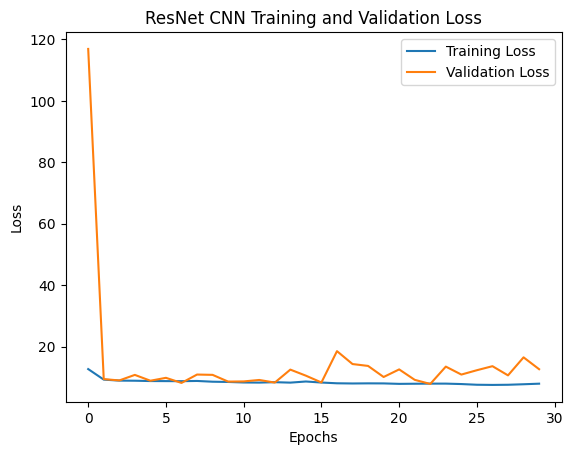

In [151]:
import matplotlib.pyplot as plt
epochs = np.arange(30)
plt.plot(epochs, train_losses[:30], label='Training Loss')
val_losses = np.asarray(val_losses)
plt.plot(epochs, val_losses[:30], label='Validation Loss')

plt.title('ResNet CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig("/kaggle/working/Loss_plot.png")
plt.show()


In [145]:
best_path = "/kaggle/working/182_proj_logs_cross_entropy/best_model.pth"
best_model = torch.load(best_path)

/tmp/ipykernel_31/2818778956.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(best_path)


In [146]:
print(best_model.keys())

dict_keys(['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss'])


In [147]:
best_model["best_val_loss"]

0.5833333333333334

In [148]:
avg_val_loss = 0
val_correct = 0
val_total = 0
val_label_correct = 0
model = VehicleCounterNet().to(device)
model.load_state_dict(best_model["model_state_dict"])
count_preds = []
count_true = []
dist_true = []
dist_preds = []
with torch.no_grad():
    model.eval()
    for images, labels, counts in val_loader:
        images = images.to(device).float()
        labels = labels.to(device).float()
        counts = counts.to(device).long()#.unsqueeze(1)
        count_output, label_output = model(images)
        loss = model.loss(count_output, label_output, counts, labels)
        preds = torch.argmax(count_output, dim = -1)
        count_preds.extend(preds.tolist())
        count_true.extend(counts.tolist())
        dist_true.extend(labels.tolist())
        label_preds = preds.unsqueeze(-1) * label_output
        dist_preds.extend(torch.round(label_preds).tolist())
        val_correct += (preds == counts.flatten()).sum().item()
        val_label_correct += (torch.round(label_preds).flatten() == labels.flatten()).sum().item()
        val_total += labels.size(1)

val_acc = val_correct / len(val_loader)
val_label_acc = val_label_correct / val_total
print(val_acc)
print(val_label_acc)

0.5833333333333334
0.75625


In [149]:
count_preds = np.asarray(count_preds)
count_true = np.asarray(count_true)
count_mae = np.mean(np.abs(count_preds - count_true))
diff = count_preds - count_true
within_1 = diff <= 1
print(f"Count Off by 1:", np.mean(within_1))
print(f"MAE: {count_mae}")

Count Off by 1: 0.8645833333333334
MAE: 0.8333333333333334


In [150]:
from sklearn.metrics import f1_score
dist_preds = np.asarray(dist_preds)
dist_true = np.asarray(dist_true)
f1 = 0
for i in range(dist_preds.shape[1]):
    f1 += f1_score(dist_preds[:, i], dist_true[:, i], average = "weighted")
f1 = f1/dist_preds.shape[1]
print(f"F1: {f1}")

F1: 0.7644575160946359


In [140]:
count_preds

array([5, 5, 5, 5, 5, 1, 5, 5, 1, 5, 5, 5, 5, 1, 1, 5, 1, 1, 5, 1, 4, 5,
       5, 1, 1, 1, 5, 5, 5, 1, 5, 5, 5, 5, 5, 1, 5, 5, 1, 5, 1, 1, 5, 1,
       5, 5, 5, 5, 1, 1, 1, 5, 5, 5, 1, 5, 5, 1, 1, 1, 5, 5, 5, 5, 1, 1,
       1, 5, 1, 1, 1, 5, 5, 5, 5, 5, 1, 5, 5, 1, 1, 5, 5, 1, 1, 1, 5, 5,
       5, 1, 5, 1, 1, 5, 5, 1])

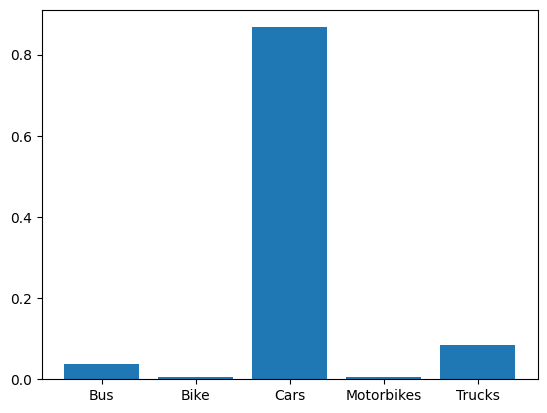

In [141]:
ys = filtered_data["labels"]
ys = torch.sum(ys, dim = 0)/torch.sum(ys)
plt.bar(range(5), ys)
plt.xticks(range(5), ["Bus", "Bike", "Cars", "Motorbikes", "Trucks"])
plt.savefig("class_imbalance.png")